In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-talk")
matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.pyplot.rcParams['savefig.facecolor'] = 'white'
sn.set_context("poster")
IPythonConsole.ipython_useSVG = False


In [2]:
trapnell_df = pd.read_csv("../embeddings/trapnell_drugs_smiles.csv", names=["drug", "smiles", "pathway"])
trapnell_df["smiles"] = trapnell_df.smiles.str.strip()
lincs_df = pd.read_csv("../embeddings/lincs_drugs_smiles.csv", names=["drug", "smiles"])
lincs_df["smiles"] = lincs_df.smiles.str.strip()

In [3]:
def tanimoto_score(input_smiles, target_smiles):
    input_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(input_smiles))
    target_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(target_smiles))
    return DataStructs.TanimotoSimilarity(input_fp, target_fp)

## Checking 3 hold out drugs
Looking for the most similar drugs in LINCS to our 3 hold out drug in Trapnell

In [4]:
loo_drugs = trapnell_df[trapnell_df.drug.isin(["Quisinostat", "Flavopiridol", "BMS-754807"])]
loo_drugs

,drug,smiles,pathway
26,BMS-754807,CC1(C(=O)Nc2ccc(F)nc2)CCCN1c1nc(Nc2cc(C3CC3)[n...,Protein Tyrosine Kinase
69,Flavopiridol,CN1CCC(c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)C...,Cell Cycle
129,Quisinostat,Cl.Cl.Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2c...,Epigenetics


In [5]:
smiles_orig = []
smiles_lincs = []
for i, (drug, smiles, pathway) in loo_drugs.iterrows():
    tanimoto_sim_col = f"tanimoto_sim_{drug}"
    lincs_df[tanimoto_sim_col] = lincs_df.smiles.apply(lambda lincs_smiles: tanimoto_score(lincs_smiles, smiles))
    most_similar = lincs_df.sort_values(tanimoto_sim_col, ascending=False).head(1)
    smiles_orig.append(smiles)
    smiles_lincs.append(most_similar["smiles"].item())
    print(drug, any(lincs_df.smiles.isin([smiles])), most_similar[tanimoto_sim_col].item(), most_similar["drug"].item())
    print(lincs_df.sort_values(tanimoto_sim_col, ascending=False).head(5)[["drug", tanimoto_sim_col]])

BMS-754807 False 1.0 BRD-K13049116
                drug  tanimoto_sim_BMS-754807
3538   BRD-K13049116                 1.000000
306    BRD-A20697603                 0.681639
772    BRD-A52627843                 0.681639
13567  BRD-K74793820                 0.678252
14761  BRD-K82109576                 0.678252
Flavopiridol False 1.0 BRD-K87909389
                drug  tanimoto_sim_Flavopiridol
15687  BRD-K87909389                   1.000000
621    BRD-A41941932                   0.719014
2316   BRD-K05433219                   0.679172
2878   BRD-K08714182                   0.669799
12064  BRD-K65639003                   0.669296
Quisinostat False 1.0 BRD-K83837640
                drug  tanimoto_sim_Quisinostat
15047  BRD-K83837640                  1.000000
1570   BRD-K00627859                  0.519417
17693  BRD-M45580279                  0.515430
14996  BRD-K83508485                  0.513755
10466  BRD-K55703048                  0.504013


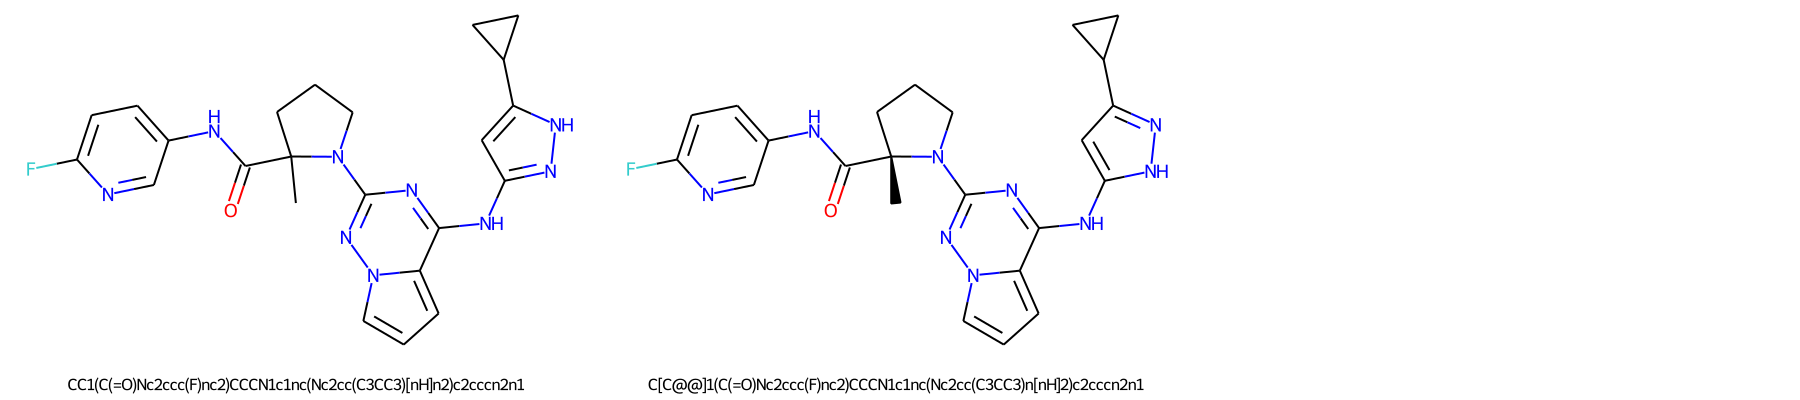

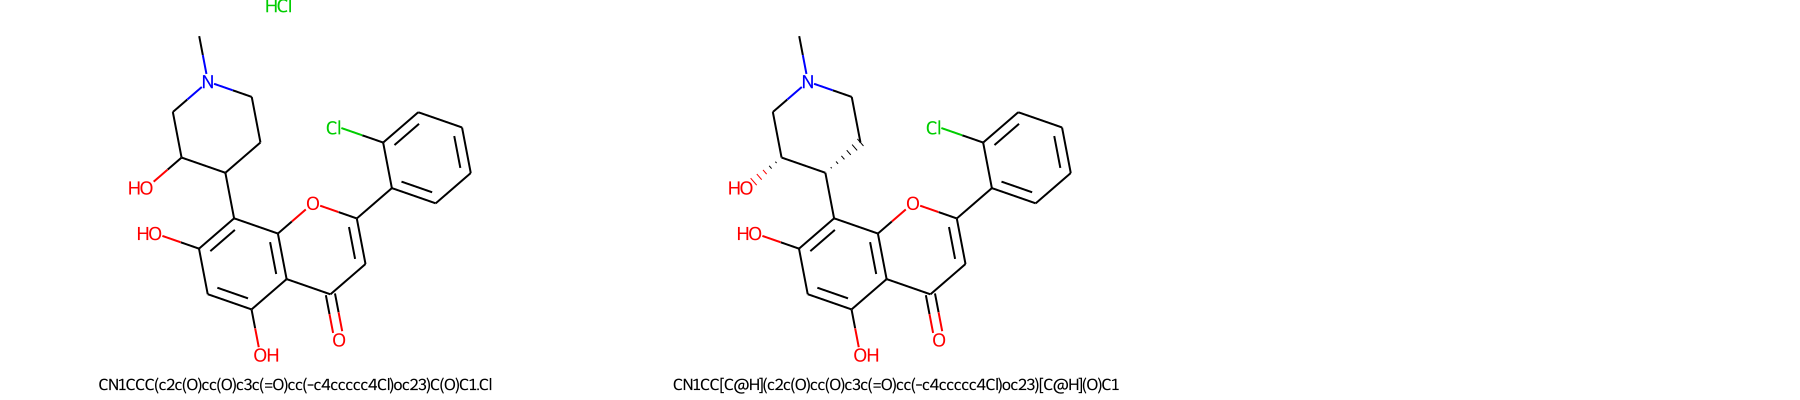

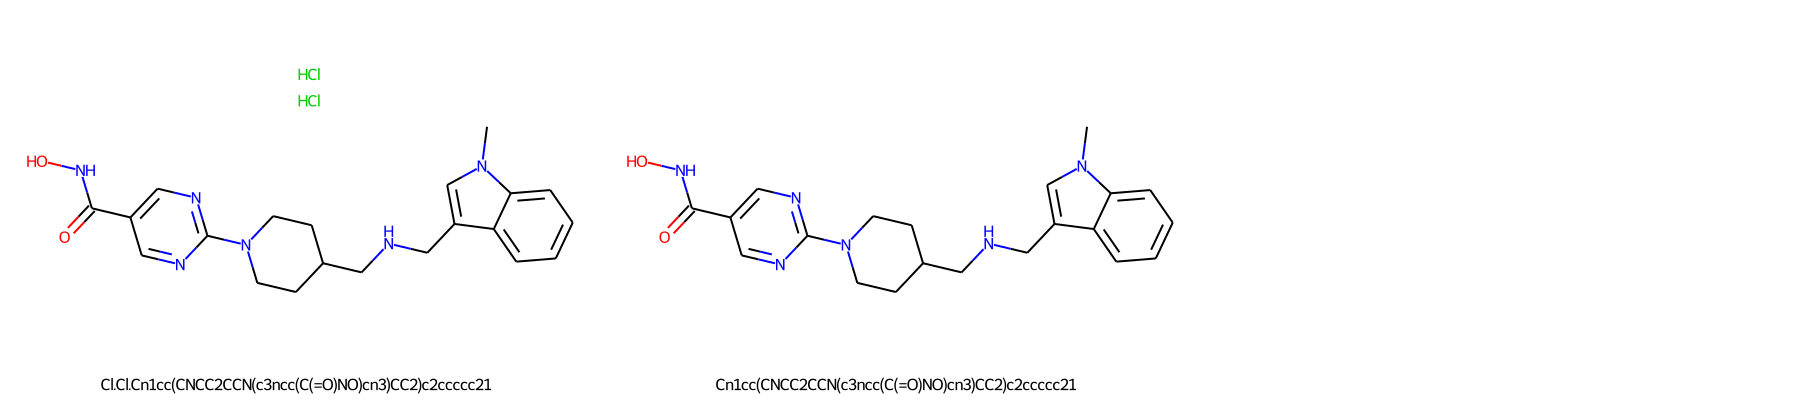

<Figure size 2080x1430 with 0 Axes>

In [6]:
for orig, lincs in zip(smiles_orig, smiles_lincs):
    im = Draw.MolsToGridImage([Chem.MolFromSmiles(orig), Chem.MolFromSmiles(lincs)], subImgSize=(600, 400),
                              legends=[orig, lincs])
    plt.tight_layout()
    display(im)